## Setup

In [ ]:
# This trick means that if all the cells are reran, this cell is skipped
%%capture ALREADY_RAN_PIP
try:
    ALREADY_RAN_PIP
except:
    !pip install astropy lightkurve matplotlib transitleastsquares

In [ ]:
# This makes sure that we are using Tensorflow 2
try:
    # Note: %tensorflow_version only exists in Google Colab
    %tensorflow_version 2.x
except Exception:
    pass

import astropy
import tensorflow as tf
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from transitleastsquares import transitleastsquares

%matplotlib inline

print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

lk.log.setLevel('WARN')
tpf = lk.search_targetpixelfile('HAT-P-11', sector=14, cadence='short').download()

2.6.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Helper Functions

In [ ]:
class Noise:
    @staticmethod
    def no_noise(x):
        """This function adds no noise, we use this as a way of comparing the autoencoder when there's no input noise"""
        x = tf.dtypes.cast(x, tf.float32)
        return x

    @staticmethod
    def random_noise(x):
        """This function should add a random uniform tensor of the shape of x between -0.3 to 0.3 to x and then clip it between 0 and 1."""
        x = tf.dtypes.cast(x, tf.float32)
        noised = x + tf.random.uniform(x.shape, minval=-0.3, maxval=0.3)
        return tf.clip_by_value(noised, 0, 1)

    @staticmethod
    def random_scale(x):
        """This function should multiply a random uniform tensor of the shape of x between 0 to 2.0 to x and then clip it between 0 and 1."""
        x_float = tf.dtypes.cast(x, tf.float32)
        noised = tf.math.multiply(x_float, tf.random.uniform(x_float.shape, minval=0.0, maxval=2.0))
        return tf.clip_by_value(noised, 0, 1)


SAMPLES_PER_DAY = 1 + 60 * 24 // 2


def fit_model(lc):
    pg = lc.to_periodogram(method='bls', duration=0.2, minimum_period=1.0)
    pg.plot()
    lc.fold(pg.period_at_max_power).scatter()
    print(pg.period_at_max_power.value)

    model = transitleastsquares(lc.time.value, lc.flux.value)
    results = model.power(period_min=pg.period_at_max_power.value *
                          0.9, period_max=pg.period_at_max_power.value*1.1)
    results.CDPP = lc.estimate_cdpp()
    return results


def plot_results(results):
    plt.figure()
    ax = plt.gca()
    ax.axvline(results.period, alpha=0.4, lw=3)
    plt.xlim(np.min(results.periods), np.max(results.periods))
    for n in range(2, 10):
        ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
        ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
    plt.ylabel(r'SDE')
    plt.xlabel('Period (days)')
    plt.plot(results.periods, results.power, color='black', lw=0.5)
    plt.xlim(0, max(results.periods))


def print_results(results):
    print('Period', format(results.period, '.5f'), 'd')
    try:
        print(len(results.transit_times), 'transit times in time series:', 
            ['{0:0.5f}'.format(i) for i in results.transit_times])
    except TypeError:
        pass
    print('Transit depth', format(results.depth, '.5f'))
    print('Transit duration (days)', format(results.duration, '.5f'))
    print('SNR', results.snr)
    print('chi2', results.chi2_min)
    print('CDPP', results.CDPP)


def plot_result_fit(results, ylim=None):
    plt.figure()
    if ylim is not None:
        plt.ylim(ylim)
    plt.plot(results.model_folded_phase,
             results.model_folded_model, color='red')
    plt.scatter(results.folded_phase, results.folded_y,
                color='blue', s=10, alpha=0.5, zorder=2)
    plt.xlabel('Phase')
    plt.ylabel('Relative flux')

    plt.figure()
    flux_error = results.model_folded_model - results.folded_y
    plt.plot(results.model_folded_phase, flux_error)
    plt.xlabel('Phase')
    plt.ylabel(f'Relative flux Error (std: {np.std(flux_error)}')


def fit_and_report(lc):
    samples_per_day = 1 + 60 * 24 // 2
    lc = lc.remove_outliers()
    lc = lc.flatten(samples_per_day)
    results = fit_model(lc)
    print_results(results)
    plot_results(results)
    plot_result_fit(results)


def scale_flux(tpf_flux: np.ndarray):
    min_flux = tpf_flux.min()
    max_flux = tpf_flux.max()
    tpf_flux_scaled = np.divide(tpf_flux - min_flux, max_flux - min_flux)
    return tpf_flux_scaled, min_flux, max_flux


def descale_flux(tpf_flux: np.ndarray, min_flux, max_flux):
    return np.multiply(tpf_flux, max_flux - min_flux) + min_flux

def banner(text: str):
    text = f' {text} '
    BANNER_WIDTH = 60
    left_width = len(text) // 2
    right_width = len(text) - left_width
    print('_' * BANNER_WIDTH)
    print('=' * (BANNER_WIDTH // 2 - left_width - 1), end='')
    print(text, end='')
    print('=' * (BANNER_WIDTH // 2 - right_width - 1))
    print('‾' * BANNER_WIDTH)

# Basic AutoEncoder (Part 2)
Just a basic AutoEncoder which was adapted from the Part 1 AutoEncoder.

## Classes
Note the modifications made since Part 1 were to change the decoder's layers so that a 1x1x10 image is TransposeConvoluted up to a 11x11x1 image (the same as the input). This included
 - Modifying the decoder's L1_W (layer 1 weights) dimensions
 - Modifying the decoder's L1_B (layer 1 bias) dimensions
 - Changing decoder's layer 2 and 3 to valid padding
 - Reducing the output channels in the decoder's layer 3 from 3 to 1

No changes were made to the Encoder, however it produced a smaller encoded image. The layer sizes were:
 - 11x11x1 **INPUT**
 - 6x6x10 (after conv_1)
 - 3x3x10 (after conv_2)
 - 1x1x10 **CODE LAYER** (after conv_3)
 - 2x2x10 (after deconv_1)
 - 5x5x10 (after deconv_2)
 - 11x11x1 **OUTPUT** (after deconv_3)


In [ ]:
class BasicAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(BasicAutoEncoder, self).__init__()

        class Encoder(tf.keras.layers.Layer):
            def __init__(self):
                super(Encoder, self).__init__()
                initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.1)
                self.encoder_conv_1 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
                self.encoder_conv_2 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
                self.encoder_conv_3 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'valid', kernel_initializer=initializer, bias_initializer=initializer)
            
            @tf.function
            def call(self, images):
                for layer in [self.encoder_conv_1, self.encoder_conv_2, self.encoder_conv_3]:
                    images = layer(images)
                    images = tf.nn.leaky_relu(images, 0.2)
                return images

        
        class Decoder(tf.keras.layers.Layer):
            def __init__(self):
                super(Decoder, self).__init__()
                initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.1)

                self.L1_W = tf.Variable(tf.random.normal([2, 2, 10, 10], dtype=tf.float32, stddev=0.1))
                self.L1_b = tf.Variable(tf.random.truncated_normal([1, 2, 2, 10], dtype=tf.float32, stddev=0.1))

                self.decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(10, 3, (2, 2), 'valid', kernel_initializer=initializer, bias_initializer=initializer)
                self.decoder_deconv_3 = tf.keras.layers.Conv2DTranspose(1, 3, (2, 2), 'valid', kernel_initializer=initializer, bias_initializer=initializer, )
                
            @tf.function
            def call(self, encoder_output):
                output_shape = (encoder_output.shape[0], 2, 2, 10)
                deconv_1 = tf.nn.conv2d_transpose(encoder_output, self.L1_W, output_shape, 2)
                deconv_1_with_bias = tf.add(deconv_1, self.L1_b)
                deconv_1_activated = tf.nn.leaky_relu(deconv_1_with_bias, alpha=0.2)

                deconv_2 = self.decoder_deconv_2(deconv_1_activated)
                deconv_2_activated = tf.nn.leaky_relu(deconv_2, alpha=0.2)

                deconv_3 = self.decoder_deconv_3(deconv_2_activated)
                deconv_3_activated = tf.nn.leaky_relu(deconv_3, alpha=0.2)

                return deconv_3_activated

        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @tf.function
    def call(self, images):
        z = self.encoder.call(images)
        return self.decoder.call(z)
    
    @tf.function
    def loss_function(self, encoded, originals):
        encoded = tf.dtypes.cast(encoded, tf.float32)
        originals = tf.dtypes.cast(originals, tf.float32)
        return tf.math.reduce_sum(tf.math.square(encoded - originals))


    def train(self, optimizer, images, noise_function):
        """Train loop for training"""
        corrupted = tf.reshape(noise_function(images), [-1, 11, 11, 1])
    
        with tf.GradientTape() as tape:
            encoded = self.call(corrupted)
            loss = self.loss_function(encoded, corrupted)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    def total_loss(self, images, noise_function):
        """This function that calculates the total loss over the entire data set, we use this to track the loss over each epoch"""
        sum_loss = 0
        corrupted = tf.reshape(noise_function(images), [-1, 11, 11, 1])
        predictions = self.call(corrupted)
        sum_loss += model.loss_function(predictions, corrupted).numpy()
        return sum_loss

## Training and Plotting Results
Compare the Part 2 model to the original and Tess lightcurves. The autoencoder seems to lower the SNR and increase the chi2 and CDPP (all bad). This is fine because it is likely just due to it "smoothing important features"


____________________________________________________________
======================== TRAINING ========================
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Epoch: 00 | Loss: 24504.97265625
Epoch: 01 | Loss: 23045.0703125
Epoch: 02 | Loss: 22458.169921875
Epoch: 03 | Loss: 22012.111328125
Epoch: 04 | Loss: 21883.859375
Epoch: 05 | Loss: 21590.767578125
Epoch: 06 | Loss: 21630.81640625
Epoch: 07 | Loss: 21598.04296875
Epoch: 08 | Loss: 21335.16796875
Epoch: 09 | Loss: 21322.9453125
____________________________________________________________
====================== ORIGINAL TPF ======================
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
4.840630921203223
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18403 data points, 127 periods from 4.357 to 5.32 days
Using all 2 CPU threads


100%|██████████| 127/127 periods | 00:07<00:00


Searching for best T0 for period 4.88363 days


100%|██████████| 6113/6113 [00:03<00:00, 1685.45it/s]


Period 4.88363 d
5 transit times in time series: ['1687.21528', '1692.09891', '1696.98254', '1701.86617', '1706.74980']
Transit depth 0.99890
Transit duration (days) 0.08376
SNR 20.350950794327527
chi2 17952.709713173328
CDPP 214.0012316002304 ppm
____________________________________________________________
========================== TESS ==========================
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18249 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:06<00:00


Searching for best T0 for period 4.88363 days


100%|██████████| 13223/13223 [00:06<00:00, 1957.44it/s]
/usr/local/lib/python3.7/dist-packages/transitleastsquares/main.py:404: UserWarning: 3 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


Period 4.88363 d
5 transit times in time series: ['1687.21393', '1692.09756', '1696.98118', '1701.86481', '1706.74844']
Transit depth 0.99882
Transit duration (days) 0.03841
SNR 10.019899657964334
chi2 17771.614242573254
CDPP 140.12675155851358 ppm
____________________________________________________________
================ NEURAL NETWORK PROCESSED ================
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18422 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:06<00:00


Searching for best T0 for period 4.88363 days


100%|██████████| 7458/7458 [00:03<00:00, 1952.40it/s]


Period 4.88363 d
5 transit times in time series: ['1687.21470', '1692.09833', '1696.98196', '1701.86559', '1706.74922']
Transit depth 0.99824
Transit duration (days) 0.06869
SNR 24.923631149592964
chi2 17738.92551430447
CDPP 283.6496900609203 ppm


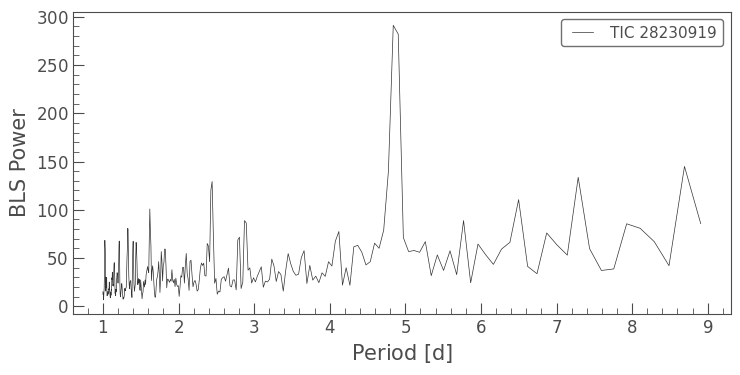

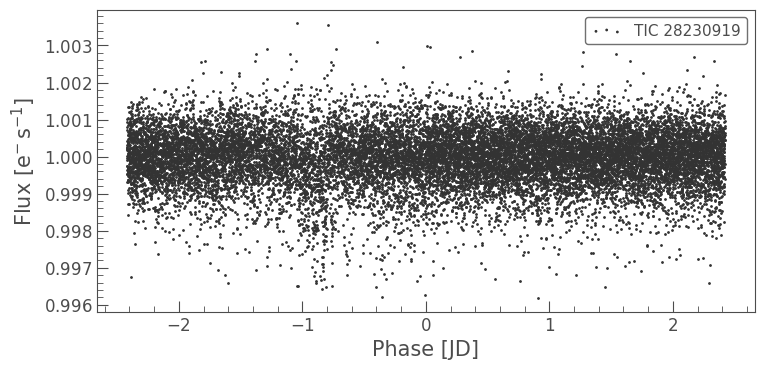

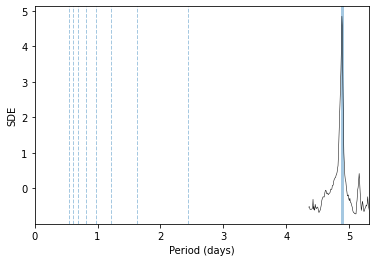

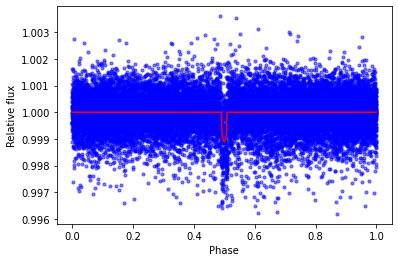

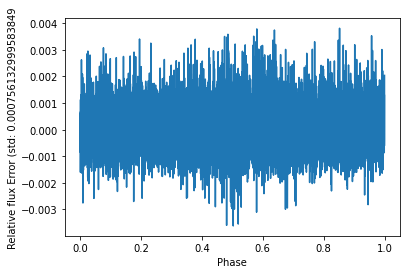

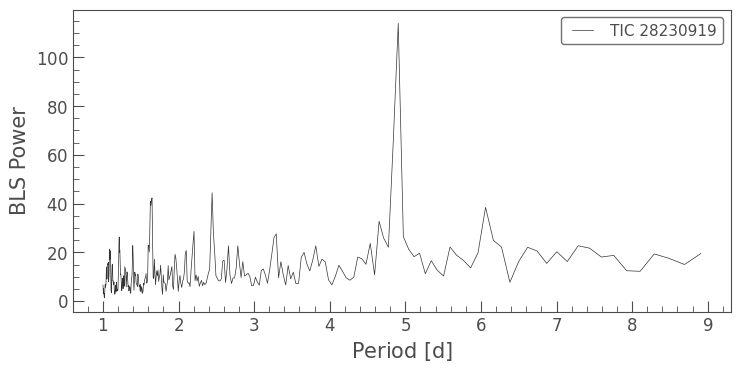

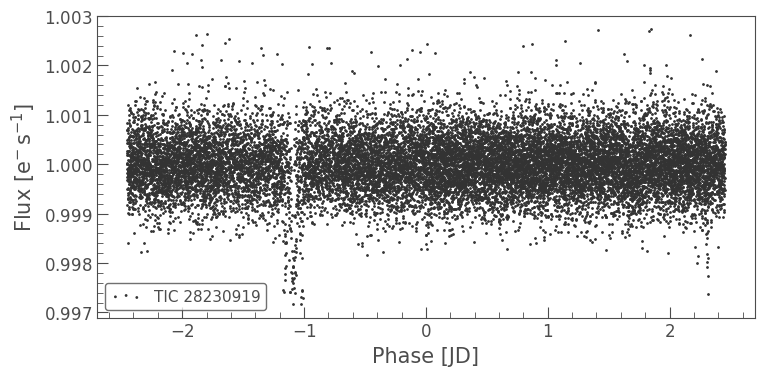

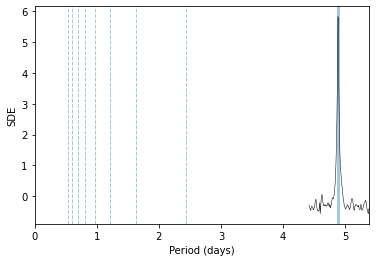

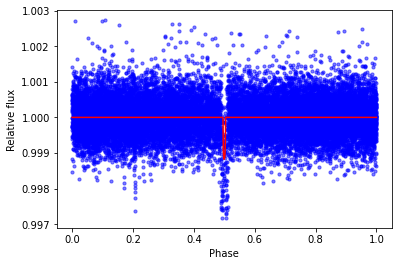

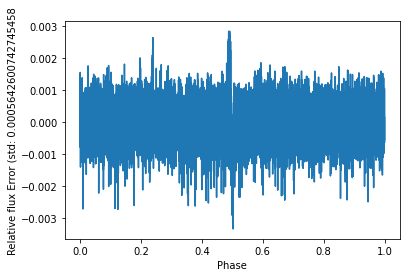

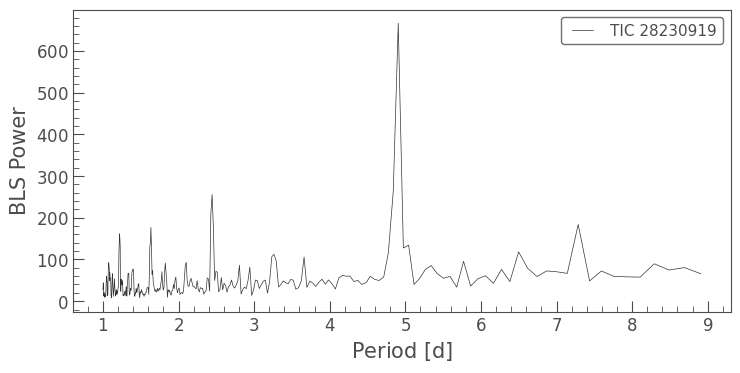

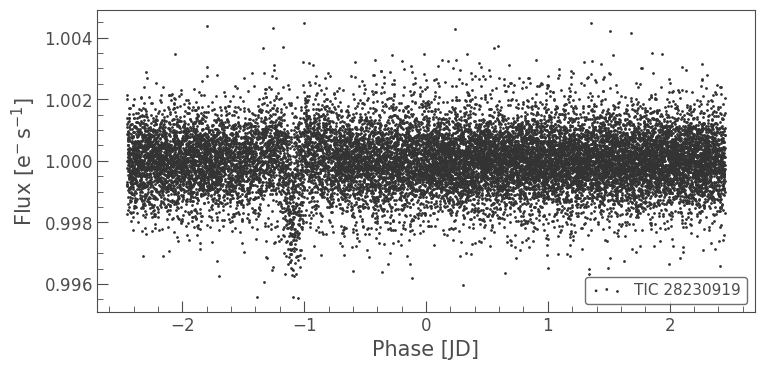

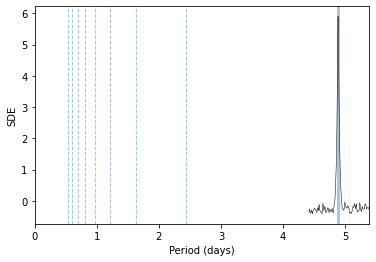

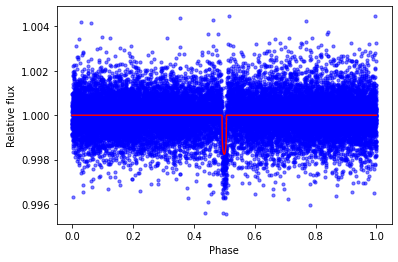

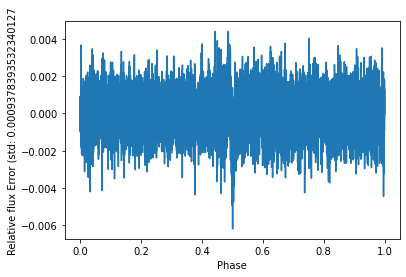

In [ ]:
# ------------------------------------------------------------------------------
# Train a basic AutoEncoder to remove noise from the original images
# ------------------------------------------------------------------------------
banner('TRAINING')
train_images = scale_flux(tpf.flux)[0]
test_images = train_images.copy()
N_EPOCHS = 10
BATCH_SIZE = 100
NOISE_FUNCTION = Noise.random_noise

model = BasicAutoEncoder()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for i in range(N_EPOCHS):
    for j in range(0, len(train_images), BATCH_SIZE):
        model.train(optimizer, train_images[j:j+BATCH_SIZE], NOISE_FUNCTION)

    sum_loss = model.total_loss(test_images, NOISE_FUNCTION)
    print(f"Epoch: {str(i).rjust(2, '0')} | Loss: {sum_loss}")


# ------------------------------------------------------------------------------
# Results
# ------------------------------------------------------------------------------
samples_per_day = 1 + 60 * 24 // 2
num_good_images = tpf.quality_mask.sum()

banner('ORIGINAL TPF')
original_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
original_lc_flat = original_lc.flatten(samples_per_day)
fit_and_report(original_lc_flat)

banner('TESS')
tess_lc = lk.search_lightcurve('HAT-P-11', sector=14, cadence='short').download()
tess_lc_flat = tess_lc.flatten(samples_per_day)
fit_and_report(tess_lc_flat)

banner('NEURAL NETWORK PROCESSED')
original_flux = tpf.hdu[1].data['FLUX'].copy()
tpf_flux_scaled, min_flux, max_flux = scale_flux(tpf.flux) # scale between 0 and 1
nn_tpf_flux_denoised = model(tpf_flux_scaled.reshape([num_good_images, 11, 11, 1]))
nn_tpf_flux_denoised = nn_tpf_flux_denoised.numpy().reshape([num_good_images, 11, 11])
nn_tpf_flux_denoised_descaled = descale_flux(nn_tpf_flux_denoised, min_flux, max_flux) # scale back
tpf.hdu[1].data['FLUX'][tpf.quality_mask] = nn_tpf_flux_denoised_descaled
nn_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
tpf.hdu[1].data['FLUX'] = original_flux # reset flux
nn_lc_flat = nn_lc.flatten(samples_per_day)
fit_and_report(nn_lc_flat)

# Improved AutoEncoder (Part 3)

## Model
The train function takes in a `noise_std_dev` parameter which is the parameter that was optimised (as specified in the report).

In [ ]:
from tensorflow.keras.layers import Conv1D, Conv1DTranspose

def train(noise_std_dev: float):
    BATCH_SIZE = 100
    LATENT_DIMENSION = 1000
    N_EPOCHS = 300

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    num_good_images = int(tpf.quality_mask.sum())

    original_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
    original_lc_flat = original_lc.flatten(SAMPLES_PER_DAY)
    original_lc_flux_scaled = scale_flux(original_lc_flat.flux)[0] # scale between 0 and 1
    train_data = original_lc_flux_scaled.reshape((1, num_good_images, 1))

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.GaussianNoise(noise_std_dev))
    model.add(tf.keras.layers.Conv1D(100, 5, 2, 'same', activation='relu'))
    model.add(tf.keras.layers.Conv1D(100, 5, 2, 'same', activation='relu'))
    model.add(tf.keras.layers.Conv1D(100, 5, 2, 'same', activation='relu'))
    model.add(tf.keras.layers.Conv1DTranspose(100, 5, 2, 'same', activation='relu'))
    model.add(tf.keras.layers.Conv1DTranspose(100, 5, 2, 'same', activation='relu'))
    model.add(tf.keras.layers.Conv1DTranspose(1, 5, 2, 'same', activation='relu'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    model.fit(train_data, train_data, epochs=N_EPOCHS, verbose=0)
    return model

## Example Usage (short test)
Call the autoencoder with layer 1 standard deviation (`noise_std_dev`) of 0.1. It should produce a SNR of about 70-90

____________________________________________________________
========== Original Lightcurve (for comparison) ==========
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:07<00:00


Searching for best T0 for period 4.88363 days


100%|██████████| 6161/6161 [00:03<00:00, 1938.74it/s]


Period 4.88363 d
5 transit times in time series: ['1687.21692', '1692.10055', '1696.98418', '1701.86781', '1706.75143']
Transit depth 0.99788
Transit duration (days) 0.08312
SNR 39.783440666891394
chi2 16865.490031358288
CDPP 224.99607989783468 ppm
____________________________________________________________
========== Denoised Lightcurve (Neural Network) ==========
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Training...
Filtering...
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:08<00:00


Searching for best T0 for period 4.88363 days


100%|██████████| 6161/6161 [00:03<00:00, 1899.41it/s]


Period 4.88363 d
5 transit times in time series: ['1687.21613', '1692.09976', '1696.98339', '1701.86701', '1706.75064']
Transit depth 0.99795
Transit duration (days) 0.08312
SNR 84.56810737158324
chi2 14014.233512829038
CDPP 99.45292384203158 ppm


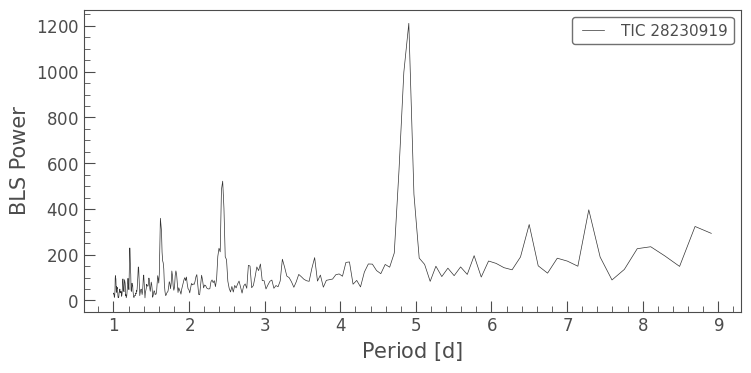

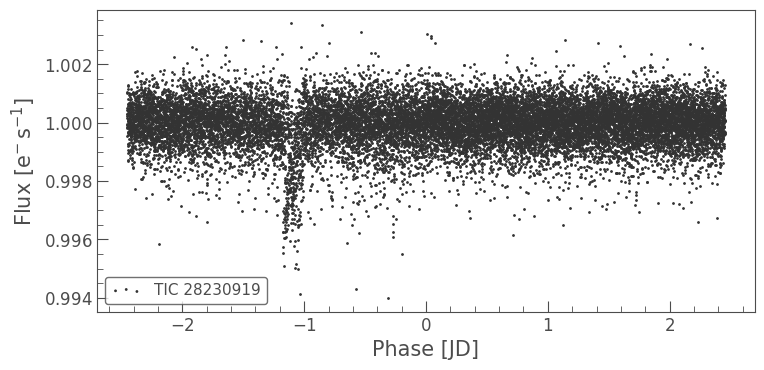

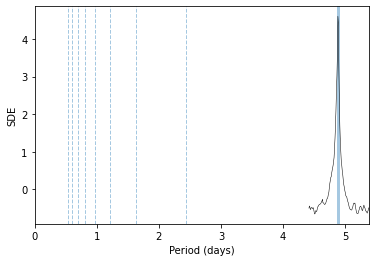

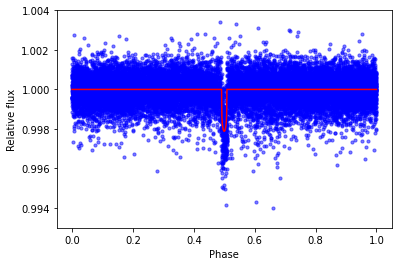

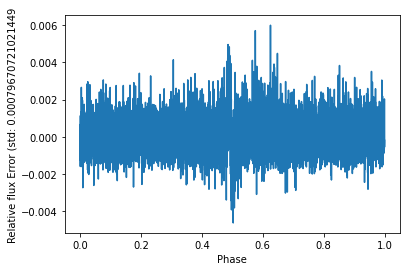

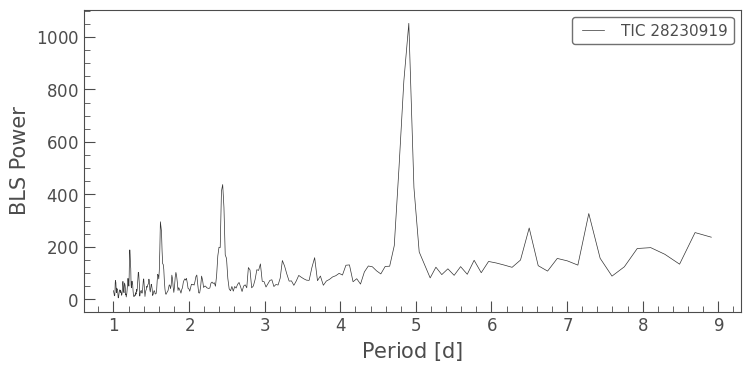

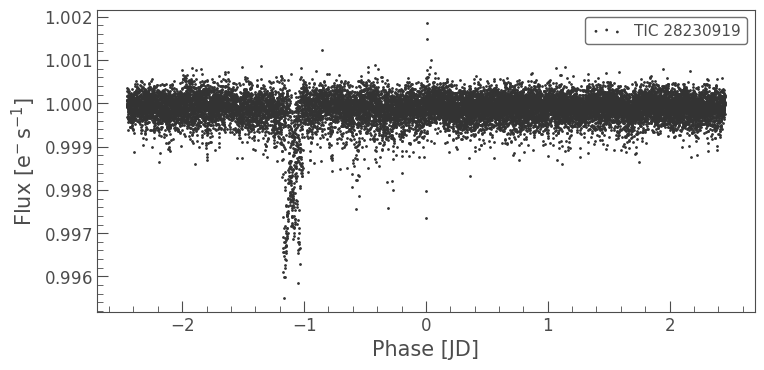

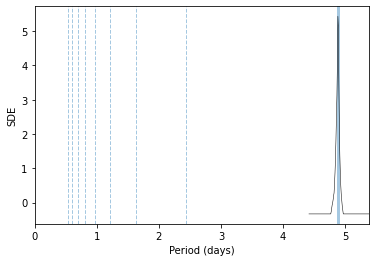

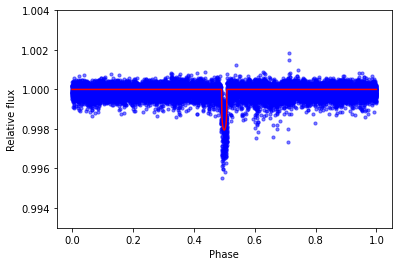

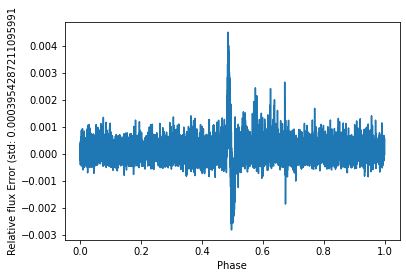

In [ ]:
banner('Original Lightcurve (for comparison)')
original_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
original_lc_flat = original_lc.flatten(SAMPLES_PER_DAY)
original_lc_results = fit_model(original_lc_flat)
print_results(original_lc_results)
plot_results(original_lc_results)
plot_result_fit(original_lc_results, ylim=[0.993, 1.004])



banner('Denoised Lightcurve (Neural Network)')
print('Training...')
model = train(0.1)
tf.keras.utils.plot_model(model, show_shapes=True)

print('Filtering...')
nn_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
nn_lc_flat = nn_lc.flatten(SAMPLES_PER_DAY)
nn_lc_flux_scaled, min_flux, max_flux = scale_flux(nn_lc_flat.flux) # scale between 0 and 1
nn_lc_flux_denoised_scaled = model.predict(nn_lc_flux_scaled.reshape((1, -1, 1))).reshape((-1))
nn_lc_flux_denoised = descale_flux(nn_lc_flux_denoised_scaled, min_flux, max_flux)
nn_lc_flat.flux = nn_lc_flux_denoised
nn_lc_results = fit_model(nn_lc_flat)
print_results(nn_lc_results)
plot_results(nn_lc_results)
plot_result_fit(nn_lc_results, ylim=[0.993, 1.004])

## Long Test (for report graph)
This block is for training and testing the Autoencoder with different layer 1 standard deviations as specified by `noise_std_deviations`.  
It takes a while and was used to incrementally get the results for the plot

In [ ]:
results = [] # declared here in case cell below fails halfway through

In [ ]:
def evaluate(lc_flat: lk.LightCurve) -> float:
    results = fit_model(lc_flat)
    return results.snr

banner('Denoised Lightcurve (Neural Network)')
noise_std_deviations = np.linspace(0.001, 0.01, 10)
noise_std_deviations = noise_std_deviations[len(results):] # allows resuming halfway through
for noise_std_deviation in noise_std_deviations:
    model = train(noise_std_deviation)
    nn_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
    nn_lc_flat = nn_lc.flatten(SAMPLES_PER_DAY)
    nn_lc_flux_scaled, min_flux, max_flux = scale_flux(nn_lc_flat.flux) # scale between 0 and 1
    nn_lc_flux_denoised_scaled = model.predict(nn_lc_flux_scaled.reshape((1, -1, 1))).reshape((-1))
    nn_lc_flux_denoised = descale_flux(nn_lc_flux_denoised_scaled, min_flux, max_flux)
    nn_lc_flat.flux = nn_lc_flux_denoised
    snr = evaluate(nn_lc_flat)
    results.append((noise_std_deviation, snr))
    banner(f'SNR={snr} for noise_std_deviation={noise_std_deviation}')

In [ ]:
for result in results:
    print(result[0], result[1])